In [464]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, confusion_matrix

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck, compute_distance_matrix

import hydra
from hydra.experimental import initialize, compose

torch.manual_seed(4444)
np.random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

In [465]:
with initialize(config_path="configs"):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

In [466]:
n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

length = cfg_model.length # each observation is a vector of size (1,length)

## Generate observations

In [467]:
#X = sin_cos(n, length)
#X = wind(num_elems=length)

X1 = arma(n//3, length, ar=[0, -0.5] , ma=[0, 0.1])
X2 = arma(n//3, length, ar=[0, 0, 0.7] , ma=[0, 0, 0.05])
X3 = arma(n//3, length, ar=[0, 0, 0, 0, -0.6] , ma=[0, 0, 0, 0, 0.2])

X = np.r_[X1,X2,X3]

c1 = np.array([0]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
c2 = np.array([1]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
c3 = np.array([2]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
Y = np.concatenate((c1,c2,c3), axis=0)
X = np.concatenate((X,Y), axis=2)

idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]
print("shape of X_train, X_valid, X_test:", X_train.shape, X_valid.shape, X_test.shape)

shape of X: torch.Size([1200, 1, 65])
shape of X_train, X_valid, X_test: torch.Size([1000, 1, 65]) torch.Size([100, 1, 65]) torch.Size([100, 1, 65])


# Data Exploration

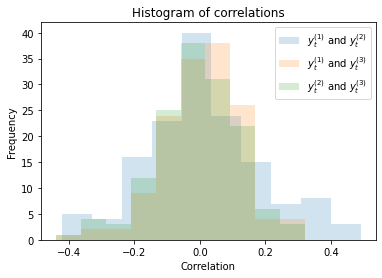

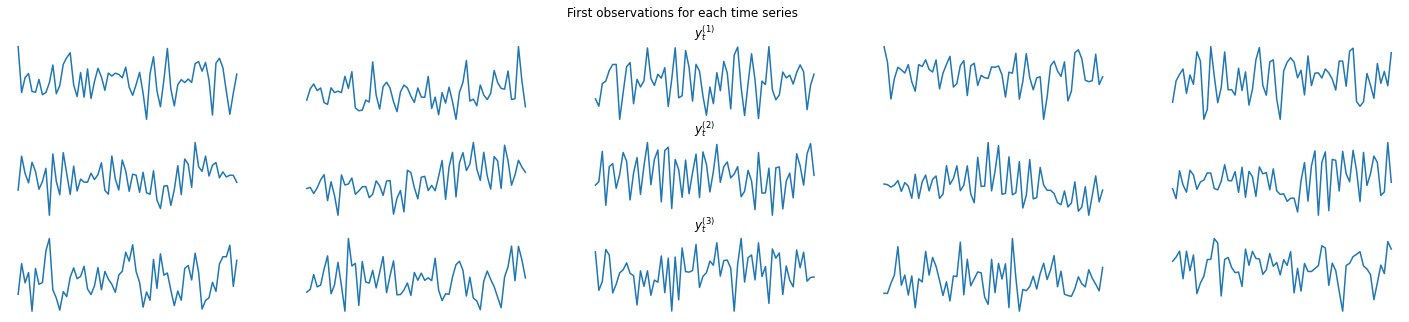

In [468]:
cors12 = scipy.stats.spearmanr(X1[0:10,0,:-1], X2[0:10,0,:-1], axis=1).correlation
cors12 = [cors12[i,j] for j in range(10,20) for i in range(j)]
plt.hist(cors12, label=r"$y_t^{(1)}$ and $y_t^{(2)}$", alpha=0.2)

cors13 = scipy.stats.spearmanr(X1[0:10,0,:-1], X3[0:10,0,:-1], axis=1).correlation
cors13 = [cors13[i,j] for j in range(10,20) for i in range(j)]
plt.hist(cors13, label=r"$y_t^{(1)}$ and $y_t^{(3)}$", alpha=0.2)

cors23 = scipy.stats.spearmanr(X2[0:10,0,:-1], X3[0:10,0,:-1], axis=1).correlation
cors23 = [cors23[i,j] for j in range(10,20) for i in range(j)]
plt.hist(cors23, label=r"$y_t^{(2)}$ and $y_t^{(3)}$", alpha=0.2)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of correlations")
plt.legend()
plt.show()

n_plots = 5
fig, axs = plt.subplots(nrows=3, ncols=n_plots, figsize=(25,5))
for i in range(3):
    for j in range(n_plots):
        axs[i,j].axis("off")
        if i == 0:
            axs[0,j].plot(X1[j,0])
        elif i == 1:
            axs[1,j].plot(X2[j,0])
        else:
            axs[2,j].plot(X3[j,0])

axs[0,n_plots//2].set_title(r"$y_t^{(1)}$")
axs[1,n_plots//2].set_title(r"$y_t^{(2)}$")
axs[2,n_plots//2].set_title(r"$y_t^{(3)}$")
_ = plt.suptitle("First observations for each time series")

# Compare to baseline

In [469]:
from sklearn.neighbors import KNeighborsClassifier

best_acc = 0
best_k = 0
for i in range(1,50):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train[:,0,:-1], X_train[:,0,-1])

    ypred = neigh.predict(X_valid[:,0,:-1])
    ypred.astype(int)
    yreal = X_valid[:,0,-1].numpy()
    yreal.astype(int)

    acc = np.sum(ypred == yreal)/len(yreal)
    if best_acc < acc:
        best_acc = acc
        best_k = i
print("Best k:", best_k)
print("Accuracy:", best_acc)

Best k: 10
Accuracy: 0.79


Accuracy: 0.87


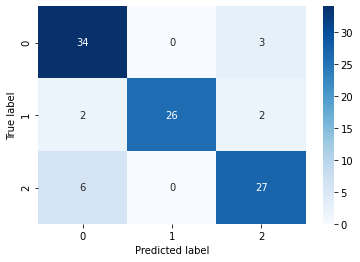

In [470]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
X_aux = np.r_[X_train, X_valid]
neigh.fit(X_aux[:,0,:-1], X_aux[:,0,-1])

ypred = neigh.predict(X_test[:,0,:-1])
ypred.astype(int)
yreal = X_test[:,0,-1].numpy()
yreal.astype(int)

cm = confusion_matrix(yreal, ypred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
print("Accuracy:", np.sum(np.diag(cm))/len(ypred))

# Model

In [471]:
model = CAE(cfg_model)

In [472]:
train_losses, valid_losses = train(model, cfg_train, X_train, X_valid)

EPOCH 10 train loss: 1.0064371805638075, valid loss: 1.0474858283996582
epochs without improvement: 0

EPOCH 20 train loss: 0.8424940630793571, valid loss: 0.9201941192150116
epochs without improvement: 1

EPOCH 30 train loss: 0.7959616631269455, valid loss: 0.8958712220191956
epochs without improvement: 1

EPOCH 40 train loss: 0.762135349214077, valid loss: 0.9199447333812714
epochs without improvement: 2

EPOCH 50 train loss: 0.7429631128907204, valid loss: 0.8669847100973129
epochs without improvement: 12

EPOCH 60 train loss: 0.7278956882655621, valid loss: 0.8829441517591476
epochs without improvement: 22

EPOCH 68 train loss: 0.7102425880730152, valid loss: 0.8861550837755203
epochs without improvement: 30

Training Finished in 30.30034303665161s


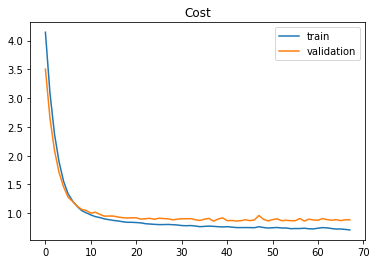

In [473]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [474]:
#torch.save(model.state_dict(), "../saved_weights/vcae_kl0.25")
#model.load_state_dict(torch.load("../saved_weights/vcae_kl0.25"))

# Testing

## Average and std correlation

avg and std: 0.6271314102564102 0.10342629663183009

cor: 0.5172619047619047
cor: 0.7387820512820511
cor: 0.5784340659340659
cor: 0.5143772893772893


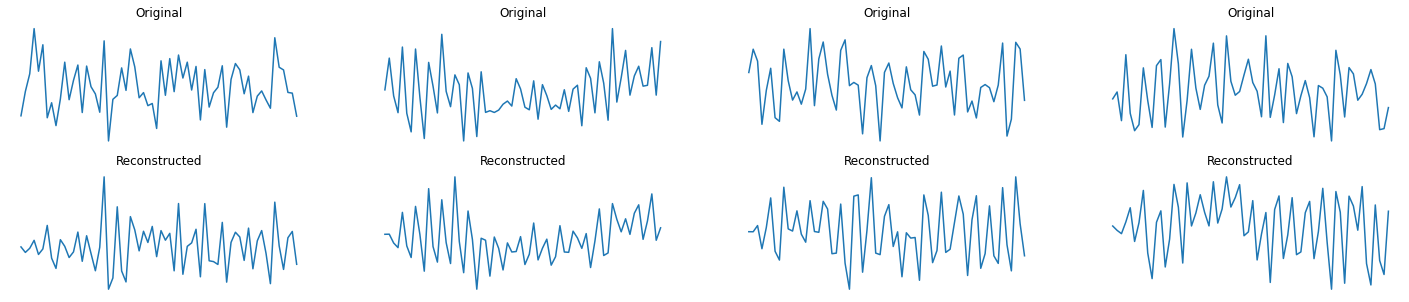

In [475]:
pred = model(X_test).detach().numpy()
inp = X_test[:,:,:-1]

# avg and std of cors
cors = [scipy.stats.spearmanr(pred[i,0], inp[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(inp[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred[start+i,0])
    print("cor:", scipy.stats.spearmanr(pred[start+i,0], inp[start+i,0]).correlation)

Accuracy: 0.83


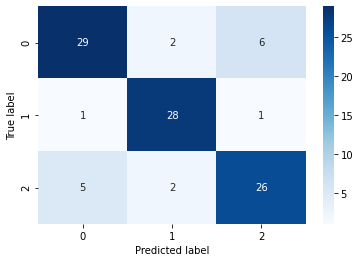

In [476]:
inp = X_test # data to perfom prediction
_, output = model(inp, get_training=True)
probs = torch.nn.functional.softmax(output, dim=1)
pred = torch.argmax(probs, dim=1).detach().numpy()
real = inp[:,:,-1].flatten().long().detach().numpy()

cm = confusion_matrix(real, pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/len(pred))

# Checking important filters

<AxesSubplot:>

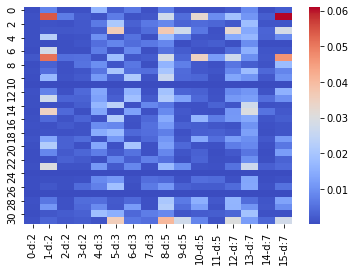

In [477]:
num_filter = len(model.dilation)*cfg_model.M
w_per_filter = cfg_model.length-cfg_model.Lf+1 # weights per filter
num_neurons = cfg_model.bottleneck_nn
M = cfg_model.M 

if isinstance(model, VCAE):
    num_neurons *= 2

w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{model.dilation[i//M]}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation